# An example of finite volume method for heat equation in polar coordinates

A Jupyter Notebook with source code is located at [this](https://github.com/krashkov/Blog) GitHub repository.

**Contents**

* The basics of FVM
* Numerical example: heat transfer problem in polar coordinates
    * Analytical solution
    * Numerical solution with FVM
        * Discretization for inner points
        * Boundary condition at $r = 0$
        * Boundary condition at $r = a$
        * Boundary condition at $r = b$
        * Final system of equations
        * Implementation
* References

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.integrate import odeint
from scipy.sparse    import diags

---

## 1 The basics of FVM

Finite volume method is a universal tool for constructing *conservative* schemes. Consider the following equation in divergence form:

$$
\frac{\partial u}{\partial t} + \frac{\partial f}{\partial x_1} + \frac{\partial f}{\partial x_2} = g(u)
$$

Integrating over arbitrary volume $V$ and applying the Divergence theorem one may obtain integral form of conservation law:

$$
\int_V \frac{\partial u}{\partial t} dV + \int_{\partial V} (\mathbf{f}, \mathbf{n}) dS = \int_V g(u) dV
$$

The main idea of FVM is to approximate this conservation law. Suppose that the computational domain $\Omega$ is divided into elements $V_i$ so that $\Omega = \cup_i V_i$. For each cell let us introduce the average value $u_i = \frac{1}{V_i} \int_{V_i} udV$. Note that $u_i$ is associated with center of $i$-th cell. Conservation law for each cell can be written as: 

$$
\frac{\partial u_i}{\partial t} + \frac{1}{V_i} \int_{\partial V_i} (\mathbf{f}, \mathbf{n}) dS = \frac{1}{V_i} \int_{V_i} g(u) dV
$$

Surface integral is equal to sum of integrals over all $N_i$ faces (edges) of $i$-th cell:

$$
\int_{\partial V_i} (\mathbf{f}, \mathbf{n}) dS = \sum_{i = 1}^{N_i} \int_{S_{\alpha}} (\mathbf{f}, \mathbf{n}) dS
$$

In most cases one may suppose that:

$$
\begin{aligned}
\frac{1}{V_i}\int_{V_i} g(u) dV &\approx g(u_i)\\
\int_{S_{\alpha}} (\mathbf{f}, \mathbf{n}) dS &\approx (\mathbf{f}_{\alpha}, \mathbf{n}_{\alpha}) S_{\alpha}
\end{aligned}
$$

where $S_{\alpha}$ is a surface area of $\alpha$-th face (length of $\alpha$-th edge), $\mathbf{n}_{\alpha}$ is an outer-pointing normal vector to $\alpha$-th face (edge) and $\mathbf{f}_{\alpha}$ is associated with center of $\alpha$-th face (edge). As a result, finite volume scheme takes the following form:

$$
\frac{\partial u_i}{\partial t} + \frac{1}{V_i} \sum_{\alpha = 1}^{N_i} (\mathbf{f}_{\alpha}, \mathbf{n}_{\alpha}) S_{\alpha} = g(u_i)
$$

It remains to specify the way of discretization of $\frac{\partial u_i}{\partial t}$ and calculation of $\mathbf{f}_{\alpha}$ in terms of $u_i$.

---

## 2 Numerical example: heat transfer problem in polar coordinates

Suppose we were asked to compute temperature evolution of electrified insulated cable or any other system which includes heat source in the form of a cylinder with $r_1=b$, thermally conductive material with $r_2=a>b$ and where heat loss occurs due to the convection and radiation.

This process can be described by the following heat transfer equation in polar coordiantes with axial symmetry:

$$
\begin{cases}
c\rho\cfrac{\partial T}{\partial t} - \cfrac{1}{r}\cfrac{\partial}{\partial r}\left(kr\cfrac{\partial T}{\partial r}\right)=q,\ 0<r<a\\
T(0, r) = T_0(r)\\
\cfrac{\partial T}{\partial r}(t, 0) = 0\\
\left(k\cfrac{\partial T}{\partial r} + \alpha (T - T_{\infty}) + \sigma T^4\right)(t,a) = 0
\end{cases}
\tag{1}
$$

where $T(t, r)$ is temperature as a function of space and time, $c$ heat capacity, $\rho$ density, $k$ thermal conductivity, $q$ describes heat source, $\alpha$ heat transfer coefficient, $T_{\infty}$ the temperature of the environment, i.e. the temperature suitably far from the surface, $\sigma$ Boltzmann constant.

In [2]:
# Inner material
c1   = 300.
rho1 = 11000.
k1   = 10.

# Outer material
c2   = 600.
rho2 = 8000.
k2   = 40.

# Other constants
q     = 2.*10**8
alpha = 500.
sigma = 5.67*10**(-8)
T_inf = 293.

# Initial temperature
T_0   = 700.

# Number of cells, radius of outer material and mesh
n      = 100
a      = 0.01
r_mesh = np.linspace(0., a, n)
h      = r_mesh[1]

# Border of inner material
b_idx = 49
b     = r_mesh[b_idx]

# Time
time_max = 100
tau      = 0.001

### 2.1 Analytical solution

Let us rewrite Eq. 1 $\left(\frac{\partial T}{\partial t} = 0\right)$ on each domain $r \in [0, b)$ and $r \in (b, a]$: 

$$
\begin{equation*}
\begin{cases}
\cfrac{d^2T_1}{dr^2}+\cfrac{1}{r}\cfrac{dT_1}{dr}=-\cfrac{q}{k_1},\ 0 < r < b\\
\cfrac{dT_1}{dr}(0) = 0
\end{cases}
\qquad\qquad
\begin{cases}
\cfrac{d^2T_2}{dr^2}+\cfrac{1}{r}\cfrac{dT_2}{dr}=0,\ b < r < a\\
\left(k_2\cfrac{dT_2}{dr} + \alpha (T_2 - T_{\infty}) + \sigma T_2^4\right)(a) = 0
\end{cases}
\end{equation*}
\tag{2}
$$

The following boundary conditions must hold at $r = b$:

$$
\begin{aligned}
T_1(b) &= T_2(b)\\
k_1\cfrac{dT_1}{dr}(b) &= k_2\cfrac{dT_2}{dr}(b)
\end{aligned}
\tag{3}
$$

$\underline{\text{Domain 1: } 0\leq r<b.}$ Directly solving the corresponding ODE one may obtain:

$$
T_1 = - \cfrac{q}{4k_1}r^2 + c_1
\tag{4}
$$

$\underline{\text{Domain 2: } b<r\leq a.}$ Similarly:

$$
T_2 = c_2\ln r + c_3
\tag{5}
$$

$$
k_2\cfrac{c_2}{a} + \alpha\left[T_2(a) - T_{\infty}\right] + \sigma [T_2(a)]^4 = 0
\tag{6}
$$

where $c_3 = T_2(a) - c_2\ln a$. Boundary conditions (2) allow to find equations for unknown constants $c_i$:

$$
c_2 = - \cfrac{qb^2}{2k_2}
\tag{7}
$$

$$
c_1 = c_2\ln b + c_3 + \cfrac{qb^2}{4k_1}
\tag{8}
$$

In [3]:
def exact_solver(k1, k2, q, alpha, sigma, T_inf, n, a, r_mesh, h, b_idx, b):
    # Find c2, see Eq. 7
    c2 = -q*b**2/(2.*k2)
    
    # Find T_2(a), see Eq. 6
    Ta = np.roots([sigma, 0, 0, alpha, k2*c2/a - alpha*T_inf])
    Ta = Ta[[(root.imag == 0. and root.real > 0.) for root in Ta]][0].real
    
    # Find c3, see Eq. 5
    c3 = Ta - c2*np.log(a)
    
    # Find c1, see Eq. 8
    c1 = c2*np.log(b) + c3 + q*b**2/(4*k1)
    
    # Find T_1 and T_2, see Eq. 4 and 5
    T         = np.zeros(len(r_mesh))
    T[:b_idx] = -q/(4*k1)*r_mesh[:b_idx]**2 + c1
    T[b_idx:] = c2*np.log(r_mesh[b_idx:]) + c3
    
    return T

In [4]:
T_exact = exact_solver(k1, k2, q, alpha, sigma, T_inf, n, a, r_mesh, h, b_idx, b)

### 2.2 Numerical solution with FVM


#### 2.2.1 Discretization for inner points 

We discretize computational domain into $n$ rings with radii $r_j=h/2+jh$ so that $r_j$ is the center of $j$-th ring and $r_{j \pm 1/2}$ are its edges. Since in a finite volume method the numerical solution is a cell-average approximation to the true solution over a grid cell:

$$
T_j = \cfrac{1}{2\pi r_j h} \int_{V_j} T(t,r) dV_j
$$

Integrating the first equation in (1) over cell $j$ and dividing by $\frac{1}{2\pi r_j h}$ we get:

$$
\cfrac{1}{2\pi r_j h} \int_{V_j} c\rho\cfrac{\partial T}{\partial t} dV_j
= \cfrac{1}{2\pi r_j h} \int_{V_j} \cfrac{1}{r}\cfrac{\partial}{\partial r}\left(kr\cfrac{\partial T}{\partial r}\right) dV_j
+ \cfrac{1}{2\pi r_j h} \int_{V_j} q dV_j
$$

$$
c\rho \cfrac{dT_j}{dt}
= \cfrac{1}{r_j h} \int_{r_{j-1/2}}^{r_{j+1/2}} \cfrac{\partial}{\partial r}\left(kr\cfrac{\partial T}{\partial r}\right) dr
+ \cfrac{1}{2\pi r_j h} \int_{V_j} q dV_j
$$

Let us define the flux $F_{j} = F_j (t) = - k r_j T_r (t, r_j)$ and local average of the source: $q_j \approx \cfrac{1}{2\pi r_j h} \int_{V_j} q dV_j$:

$$
c\rho \cfrac{dT_j}{dt}
= \cfrac{-F_{j+1/2} + F_{j-1/2}}{r_j h}
+ q_j
$$

Note, that $F_{j \pm 1/2}$ represents how much heat flows through the boundaries of the $j$-th cell.

**Approximation of the flux**

Finally, we need to approximate the fluxes:

$$
\begin{aligned}
F_{j-1/2}(t) &= -kr_{j-1/2}T_r(t, r_{j-1/2})\\
&\approx -kr_{j-1/2}\cfrac{T_j(t) - T_{j-1}(t)}{h}
\end{aligned}
$$

Similarly:

$$
F_{j+1/2}(t) \approx -kr_{j+1/2}\cfrac{T_{j+1}(t) - T_{j}(t)}{h}
$$

This leads to the numerical scheme for inner points $j \in \{1,\cdots,b_{\text{idx}}-2, b_{\text{idx}}+2,\cdots,n-2\}$:

$$
c\rho \cfrac{dT_j}{dt}
= \cfrac{kr_{j-1/2} T_{j-1} - ( kr_{j+1/2} + kr_{j-1/2} )T_j + kr_{j+1/2}T_{j+1}}{r_j h^2}
+ q
\tag{9}
$$

#### 2.2.2 Boundary condition at $r = 0$

To complete the scheme (9) we need to obtain update rules also for the boundaries. Let us introduce the ghost cell $j = 0$ which is located just outside the domain. Here L'Hopital’s rule is used to remove singularity at $r = 0$: $\lim_{r \rightarrow 0} \frac{1}{r}\frac{\partial T}{\partial r} = \frac{\partial^2 T}{\partial r^2}$. Hence, the equation takes the following form:

$$
c\rho\cfrac{\partial T}{\partial t}
=
2k \cfrac{\partial^2 T}{\partial r^2} + q
\quad\Rightarrow\quad
c\rho\cfrac{\partial T}{\partial t}
=
2k \cfrac{T_1 - 2T_0 + T_{-1}}{h^2} + q
$$

According to the boundary condition (2) $T_r(0) = 0$ the following holds: $T_{-1} = T_{1}$:

$$
j = 0:\ 
c\rho\cfrac{dT_0}{dt}
=
4k \cfrac{- T_0 + T_1}{h^2} + q
\tag{10}
$$

#### 2.2.3 Boundary condition at $r = a$

By analogy, we express boundary condition (2) using the ghost cell $j = n$:

$$
k\cfrac{T_n - T_{n-2}}{2h}(a) + \alpha (T_{n-1} - T_{\infty}) + \sigma T_{n-1}^4 = 0
$$

$$
T_n = T_{n-2} - \cfrac{\alpha 2h}{k} T_{n-1} - \cfrac{\sigma 2h}{k} T_{n-1}^4 + \cfrac{\alpha 2h}{k} T_{\infty}
$$

Then for $j = n - 1$:

$$
c\rho \cfrac{dT_{n-1}}{dt}
= \cfrac{kr_{n-3/2} T_{n-2} - ( kr_{n-1/2} + kr_{n-3/2} )T_{n-1} + kr_{n-1/2}T_{n}}{r_{n-1} h^2}
$$

$$
j = n-1:\ 
c\rho \cfrac{dT_{n-1}}{dt}
= \cfrac{(kr_{n-3/2}+kr_{n-1/2}) T_{n-2} - ( kr_{n-1/2} + kr_{n-3/2} + r_{n-1/2}\alpha 2h)T_{n-1}}{r_{n-1} h^2}
+ \cfrac{- r_{n-1/2}\sigma 2T_{n-1}^4 }{r_{n-1} h}
+ \cfrac{r_{n-1/2}\alpha 2T_{\infty}}{r_{n-1} h}
\tag{11}
$$

#### 2.2.4 Boundary condition at $r = b$

Recall that for $r = b$ must hold boundary conditions (3):

$$
k_1\cfrac{dT}{dr}(b) = k_2\cfrac{dT}{dr}(b)
\quad\Rightarrow\quad
k_1\cfrac{T_{b-2}-4T_{b-1}+3T_b}{2h} = k_2\cfrac{-3T_b + 4T_{b+1} - T_{b+2}}{2h}
$$

$$
T_b
=
- \cfrac{k_1}{3(k_1 + k_2)} T_{b-2}
+ \cfrac{4k_1}{3(k_1 + k_2)}T_{b-1}
+ \cfrac{4k_2}{3(k_1 + k_2)}T_{b+1}
- \cfrac{k_2}{3(k_1 + k_2)} T_{b+2}
\tag{12}
$$

If we write Eq. 9 for $j = b-1$ and replace $T_b$ using (12), we will get the correct update rule for $j = b-1$:

$$
\begin{multline}
j = b - 1:\ 
c_1\rho_1 \cfrac{dT_{b-1}}{dt}
=
\cfrac{
  \left(k_1r_{b-3/2} -\cfrac{k_1^2r_{b-1/2}}{3(k_1 + k_2)} \right) T_{b-2}
- \left( k_1r_{b-1/2} + k_1r_{b-3/2} - \cfrac{4k_1^2r_{b-1/2}}{3(k_1 + k_2)} \right) T_{b-1}
}
{r_{b-1} h^2} +\\
+
\cfrac{
  \cfrac{4k_2k_1r_{b-1/2}}{3(k_1 + k_2)} T_{b+1}
- \cfrac{k_2k_1r_{b-1/2}}{3(k_1 + k_2)} T_{b+2}
}
{r_{b-1} h^2}
+ q
\end{multline}
\tag{13}
$$

And for $j = b+1$:

$$
\begin{multline}
j = b + 1:\ 
c_2\rho_2 \cfrac{dT_{b+1}}{dt}
=
\cfrac{
-\cfrac{k_1k_2r_{b+1/2}}{3(k_1 + k_2)} T_{b-2}
+ \cfrac{4k_1k_2r_{b+1/2}}{3(k_1 + k_2)} T_{b-1}
}
{r_{b+1} h^2} +\\
+
\cfrac{
- \left( k_2r_{b+3/2} + k_2r_{b+1/2} - \cfrac{4k_2^2r_{b+1/2}}{3(k_1 + k_2)}\right) T_{b+1}
+ \left(k_2r_{b+3/2}-\cfrac{k_2^2r_{b+1/2}}{3(k_1 + k_2)}\right) T_{b+2}
}
{r_{b+1} h^2}
\end{multline}
\tag{14}
$$

#### 2.2.5 Final system of equations

Putting all together we recieve the following system of equations:

$$
c\rho \cfrac{d\mathbf{T}}{dt} = A\mathbf{T} + \mathbf{b} + \mathbf{q} = f(\mathbf{T})
\tag{15}
$$

where:

$$
\mathbf{T} = [T_0, T_1, \cdots, T_{n-1}]^T
$$

$$
\mathbf{q} = [q, q, \cdots, 0]^T
$$

$$
\mathbf{b} = \left[0, 0, \cdots, 
\cfrac{- 2 \sigma r_{n-1/2} T_{n-1}^4 }{r_{n-1} h}
+ \cfrac{2 \alpha r_{n-1/2} T_{\infty}}{r_{n-1} h}\right]^T
$$

$$
A =
\begin{bmatrix}
-\cfrac{4k}{h^2} & \cfrac{4k}{h^2} & 0 &\cdots & 0\\
\cfrac{kr_{1/2}}{r_1 h^2} & \cfrac{- ( kr_{3/2} + kr_{1/2} )}{r_1 h^2} & \cfrac{kr_{3/2}}{r_1 h^2} &\cdots &0\\
0 & \cfrac{kr_{3/2}}{r_2 h^2} & \cfrac{- ( kr_{5/2} + kr_{3/2} )}{r_2 h^2} &\cdots &0\\
\vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 &\cdots & \cfrac{- \left(kr_{n-1/2} + kr_{n-3/2} + r_{n-1/2}\alpha 2h\right)}{r_{n-1} h^2}\\
\end{bmatrix}
$$

#### 2.2.6 Implementation


In [5]:
def fvm_heat_solver(c1, rho1, k1, c2, rho2, k2, T0, q, alpha, sigma, T_inf, n, a, r_mesh, h, b_idx, b, time_max, tau):
    def f(T, t, A, b, Q):
        return A.dot(T) + b*T**4 + Q
    
    def return_A_b_q(c1, rho1, k1, c2, rho2, k2, q, alpha, sigma, T_inf, n, b_idx, r_int, r_frac, r_n, r_n12):
        left_diag = np.concatenate((
                       k1*r_frac[:b_idx-1]    /(r_int[1:b_idx] *h**2)/(c1*rho1),
                       k2*r_frac[b_idx-1:-1]  /(r_int[b_idx:-1]*h**2)/(c2*rho2),
            np.array([(k2*r_frac[-1]+k2*r_n12)/(r_int[-1]*h**2)      /(c2*rho2)])
        ))
        right_diag = np.concatenate((
            np.array([4*k1              /(h**2)                /(c1*rho1)]),
                      k1*r_frac[1:b_idx]/(r_int[1:b_idx] *h**2)/(c1*rho1),
                      k2*r_frac[b_idx:] /(r_int[b_idx:-1]*h**2)/(c2*rho2)
        ))
        mid_diag = np.concatenate((
            np.array([ -4*k1                                      /(h**2)])               /(c1*rho1),
            np.array(( -k1*r_frac[:b_idx-1]   -k1*r_frac[1:b_idx])/(r_int[1:b_idx]*h**2)) /(c1*rho1),
            np.array(( -k2*r_frac[b_idx-1:-1] -k2*r_frac[b_idx:]) /(r_int[b_idx:-1]*h**2))/(c2*rho2),
            np.array([-(k2*r_n12+k2*r_frac[-1]+r_n12*alpha*2*h)   /(r_int[-1]*h**2)])     /(c2*rho2)
        ))
        A = diags(
            [left_diag, mid_diag, right_diag],
            [-1, 0, 1]
        ).toarray()
        
        b     = np.zeros(n)
        b[-1] = - 2 * sigma * r_n12 / (r_int[-1] * h) / (c2 * rho2)
        
        Q         =  np.zeros(n)
        Q[:b_idx] =  q / (c1 * rho1)
        Q[b_idx:] =  0
        Q[-1]     += 2 * alpha * r_n12 * T_inf / (r_int[-1] * h) / (c2 * rho2)
        
        # Note that according with Eqs. 12-14 we do not need to compute
        # T[b_idx] and also have to modify A as in Eqs. 13, 14
        b[b_idx]   = 0
        Q[b_idx]   = 0
        
        A[b_idx,  :] = 0
        A[b_idx+1,:] = 0
        A[b_idx-1,:] = 0
        
        A[b_idx-1, b_idx-2] = k1*r_frac[b_idx-2] - k1*k1*r_frac[b_idx-1]/3/(k1+k2)
        A[b_idx-1, b_idx-1] = -(k1*r_frac[b_idx-1]+k1*r_frac[b_idx-2]-4*k1*k1*r_frac[b_idx-1]/3/(k1+k2))
        A[b_idx-1, b_idx+1] = 4*k2*k1*r_frac[b_idx-1]/3/(k1+k2)
        A[b_idx-1, b_idx+2] = -k2*k1*r_frac[b_idx-1]/3/(k1+k2)
        A[b_idx-1, :]       = A[b_idx-1, :] / (r_int[b_idx-1]*h**2)/(c1*rho1)
        
        A[b_idx+1, b_idx-2] =  -k1*k2*r_frac[b_idx]/3/(k1+k2)
        A[b_idx+1, b_idx-1] = 4*k1*k2*r_frac[b_idx]/3/(k1+k2)
        A[b_idx+1, b_idx+1] = -(k2*r_frac[b_idx+1]+k2*r_frac[b_idx]-4*k2*k2*r_frac[b_idx]/3/(k1+k2))
        A[b_idx+1, b_idx+2] = k2*r_frac[b_idx+1] - k2*k2*r_frac[b_idx]/3/(k1+k2)
        A[b_idx+1, :]       = A[b_idx+1, :] / (r_int[b_idx+1]*h**2) /(c2*rho2)
        
        return A, b, Q
    
    # Introduce integer and fractional r points
    r_int  = r_mesh
    r_frac = (r_int[:-1] + r_int[1:])/2
    
    # Calculate r_n and r_{n-1/2}
    r_n    = a + h
    r_n12  = (r_n + r_int[-1])/2
    
    # Return vectors and matrices according with Eq. 15 
    A, b, Q = return_A_b_q(c1, rho1, k1, c2, rho2, k2, q, alpha, sigma, T_inf, n, b_idx, r_int, r_frac, r_n, r_n12)
    
    T = odeint(
        func=f,
        y0=np.array([T_0]*n),
        t=np.arange(tau, time_max, tau),
        args = (A, b, Q)
    )
    
    # Calculate T[b_idx] according with Eq. 12
    T[:, b_idx] =   k1 / (k1+k2) * T[:, b_idx-1] \
                  + k2 / (k1+k2) * T[:, b_idx+1]
    
    return T

In [6]:
T_num = fvm_heat_solver(c1, rho1, k1, c2, rho2, k2, T_0, q, alpha, sigma, T_inf, n, a, r_mesh, h, b_idx, b, time_max, tau)

Define several plot functions.

In [7]:
def plot_line(T_num, T_exact, steps):
    fig, axes = plt.subplots(nrows=2, ncols=3)
    fig.set_size_inches(w=20,h=8)

    i = 0
    labels = [str(step) for step in steps]
    for ax in axes.flat:
        im = ax.plot(T_num[steps[i], :],   label = "num")
        im = ax.plot(T_exact,              label = "exct", color = 'r')
        im = ax.legend(loc="best", fontsize=15)
        i = i + 1
        
    plt.show()

In [8]:
def plot_circle(T_num, T_exact, steps, n):
    fig, axes = plt.subplots(nrows=2, ncols=3, subplot_kw=dict(projection='polar'))
    fig.set_size_inches(w=20,h=8)

    i = 0
    labels = [str(step) for step in steps]
    
    rad = np.linspace(0., a, n)
    azm = np.linspace(0, 2 * np.pi, n)
    r, th = np.meshgrid(rad, azm)
    norm = colors.Normalize(vmin=np.min(T_num),vmax=np.max(T_num))

    for ax in axes.flat:
        z = np.zeros((n, n))
        z[:, ] = T_num[steps[i], :]
        im = ax.pcolormesh(th, r, z,
                           norm=norm,
                           cmap='hot')
        fig.colorbar(im, ax=ax)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        i = i + 1
    
    plt.show()

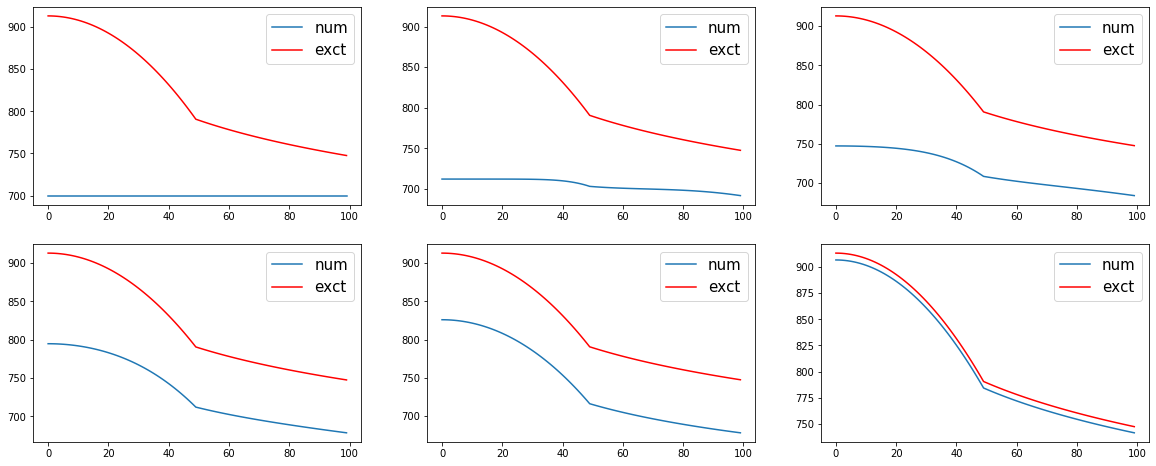

In [9]:
plot_line(T_num, T_exact, [0, 200, 800, 2000, 4000, -1])

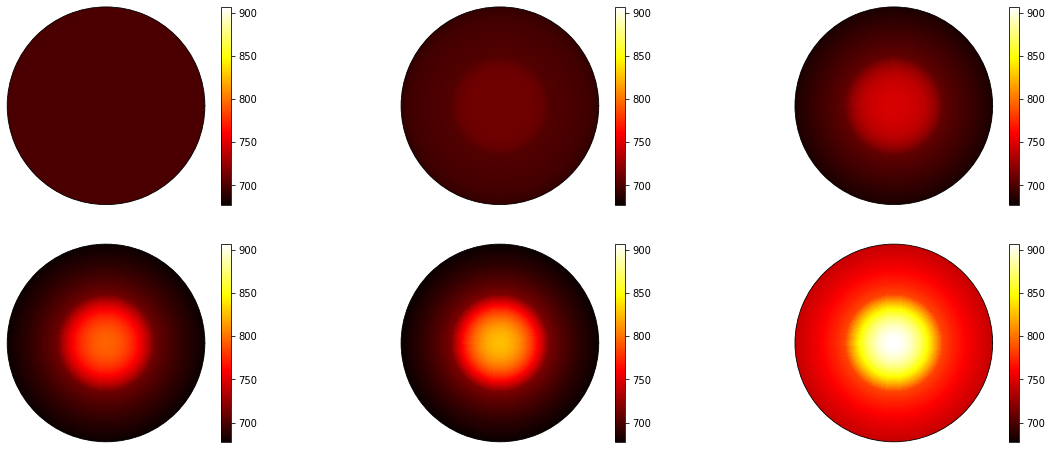

In [10]:
plot_circle(T_num, T_exact, [0, 200, 800, 2000, 4000, -1], n)

---

*References*

1. K. Gustavsson. Lecture Notes: Numerical Treatment of Differential Equations, KTH Institute of Technology [[link](http://www.csc.kth.se/utbildning/kth/kurser/DN2255/ndiff13/)]